In [3]:
# Compare local and global rate constants to show that single cell investigation is valuable since there is 
# variability between cells. Using a compiled data set and determining delta and ktl values from these larger sets omits
# the variability between individual cells. 
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import special
import scipy.stats as sps
import random
import lmfit as lm
np.random.seed(1)

In [4]:
# lets estimate the parameters for the gamma function from the data
# first by maximum likelihood
def MLE_gamma(data):
    avg = data.mean()
    s = np.log(avg) - np.log(data).mean()
    k0 = (3 - s + np.sqrt((s -3)**2 +24*s))/12/s
#    print("initial guess:",k0)
    for i in range(4):
        k = k0 - (np.log(k0)-special.digamma(k0)-s)/(1/k0-special.polygamma(1,k0))
#        print("next guess:",k)
        k0=k
    return (k,avg/k)

In [5]:
def threestage(t,t0,ktl,km,delta,beta,off=0):
    km=np.abs(km)
    ktl=np.abs(ktl)
    delta=np.abs(delta)
    beta=np.abs(beta)
    dmb = delta-beta
    bkm = beta + km
    dmbk = delta-bkm
    t0=np.abs(t0)
    dt=t-t0
    result = 1/dmb +km*np.exp(-dmb*dt)/dmb/dmbk-np.exp(-km*dt)/dmbk
    result = ktl*np.exp(-beta*dt)*result.clip(0)
    result[t<t0]=0
    return off+result
threestage_model = lm.Model(threestage)

In [6]:
rates = pd.read_excel("Translation_inhibition.xlsx")

mean:  0.005220415594360093 std:  0.003275892290003307
gamma k:  2.2443105354340154 theta:  0.002326066518843189
2.539515856345431 0.002055673557349901


/Users/joshazukas/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


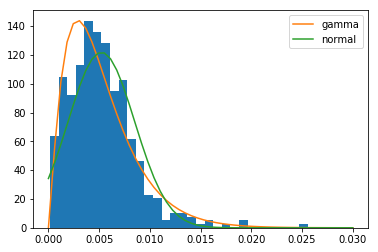

In [7]:
betg = rates["betg"]
betg = betg[~np.isnan(betg)]
print("mean: ",betg.mean(),"std: ",betg.std())
betgx = np.linspace(0,0.03)
betg_normal = sps.norm.pdf(x=betgx,loc=betg.mean(),scale=betg.std())

k_betg,theta_betg = MLE_gamma(betg)
print("gamma k: ",k_betg,"theta: ",theta_betg)
betg_gamma = sps.gamma.pdf(x=betgx,a=k_betg,scale=theta_betg)

betg_var = betg.std()**2
betg_mean = betg.mean()

betg_theta2 = betg_var/betg_mean
betg_k2 = betg_mean/betg_theta2
print(betg_k2,betg_theta2)
betg_gamma2 = sps.gamma.pdf(x=betgx,a=betg_k2,scale=betg_theta2)

plt.hist(betg, bins=30, normed=True)
plt.plot(betgx,betg_gamma,label="gamma")
plt.plot(betgx,betg_normal,label="normal")
plt.legend()

mean:  1.283028655097614 std:  0.4785823666235206
gamma k:  8.31602457913074 theta:  0.15428389405166076


/Users/joshazukas/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


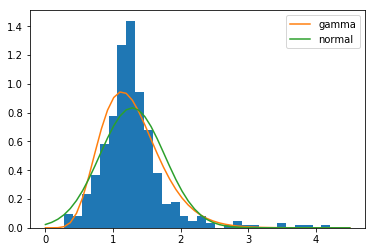

In [8]:
kmg = rates["kmg"]
kmg = kmg[~np.isnan(kmg)]

print("mean: ",kmg.mean(),"std: ",kmg.std())
kmgx = np.linspace(0,4.5)
kmg_normal = sps.norm.pdf(x=kmgx,loc=kmg.mean(),scale=kmg.std())

k_kmg,theta_kmg = MLE_gamma(kmg)
print("gamma k: ",k_kmg,"theta: ",theta_kmg)
kmg_gamma = sps.gamma.pdf(x=kmgx,a=k_kmg,scale=theta_kmg)

plt.hist(kmg,bins=30,normed=True)
plt.plot(kmgx,kmg_gamma,label="gamma")
plt.plot(kmgx,kmg_normal,label="normal")
plt.legend()

In [9]:
s_betg = np.random.gamma(k_betg, theta_betg, 1000) #draw 1000 random points from a gamma distribution 
# based on the parameters for betg gamma distribution k and theta
s_kmg = np.random.gamma(k_kmg,theta_kmg, 1000)

In [10]:
egfp = pd.read_excel("2017_06_02_seq6_Huh7_controll_#molecules.xlsx",sheet="#GFP_corrected").dropna()

In [11]:
egfp = np.array(egfp,dtype=np.double).T
egfp.shape
time = egfp[0]
egfp = egfp[1:]

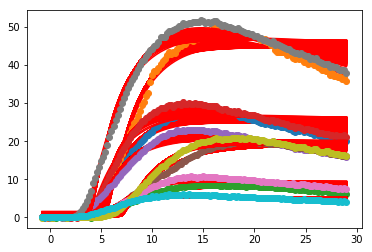

In [12]:
deltas= []        #create list for delta values and standard deviations of delta values
delt_stderr= []
ktl_val = []
ktl_stderr= []
for i in range(10):  #For complete set, change to 400
    data = egfp[i]
    for n in range(1000):
        pars = threestage_model.make_params()              #number of times we fit the curve based on a random value of Km and Beta
        pars['km'].set(value=s_kmg[n],vary=False,min=0)
        pars['ktl'].set(value=3,vary=True,min=0)
        pars['delta'].set(value=0.05,vary=True,min=0)
        pars['beta'].set(value=s_betg[n],vary=False,min=0)
        pars['t0'].set(value=5,vary=True,min=0)

        result = threestage_model.fit(data,pars,t=time)        #give results of fit and append the new delta value and stderr to list
        deltas.append(result.params['delta'].value)
        delt_stderr.append(result.params['delta'].stderr)
        ktl_val.append(result.params['ktl'].value)
        ktl_stderr.append(result.params['ktl'].stderr)
        plt.plot(time, result.best_fit, 'r-')
    plt.plot(time,data,"o")

In [24]:
deltA = np.array(deltas) #global delta
ktlA= np.array(ktl_val) #global ktl
deltstderrA= np.array(delt_stderr) #global delta error
ktlstderrA = np.array(ktl_stderr) #global ktl error

gamma k:  12.394931490488073 theta:  0.035784023337099596
mean:  0.44354051771737585 std:  0.13234688391198027


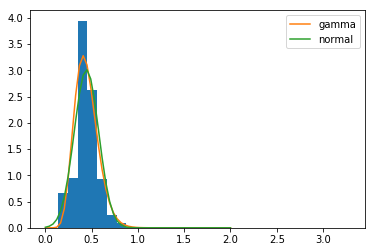

In [25]:
# Global Delta
plt.hist(deltas,bins = 30,density=True)
k_del,theta_del = MLE_gamma(deltA)
print("gamma k: ",k_del,"theta: ",theta_del)
deltx = np.linspace(0,2)
delt_gamma = sps.gamma.pdf(x=deltx,a=k_del,scale=theta_del)

print("mean: ",deltA.mean(),"std: ",deltA.std())
delt_normal = sps.norm.pdf(x=deltx,loc=deltA.mean(),scale=deltA.std())

plt.plot(deltx, delt_gamma, label='gamma')
plt.plot(deltx,delt_normal, label= 'normal')
plt.legend()
#This shows that the distribution of delta values, which appeared to be a gamma distribution at low samples, will
# become a normal distribution at larger sample sizes. We will therefore describe our delta data set as a normal 
# distribution with mean and std


In [26]:
#Local Delta
a = 1
b = 1000 # match N
deltlocgammak = []
deltlocgammatheta = []
deltnormalmean = []
deltanormalstd = []
for l in range (10): # match i, for full set change to 400
    k_del, thetadel=MLE_gamma(deltA[a:b])
    deltlocgammak.append(k_del)
    deltlocgammatheta.append(thetadel)
    delts = deltA[a:b]
    mean = delts.mean()
    stddev=delts.std()
    deltnormalmean.append(mean)
    deltanormalstd.append(stddev)
    
    a=a+1000
    b=b+1000
#Outputs list of local delta distribution parameters

gamma k:  2.3479880170926926 theta:  4.360258593876446
mean:  10.237834929847327 std:  6.746207293865682


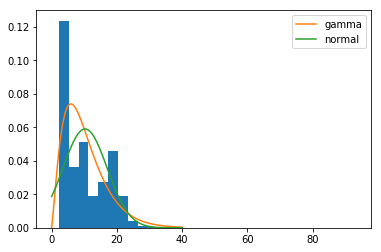

In [27]:
#Global ktl
plt.hist(ktl_val, bins = 30,density=True )
k_ktl,theta_ktl = MLE_gamma(ktlA)
print("gamma k: ",k_ktl,"theta: ",theta_ktl)
ktlx = np.linspace(0,40)
ktl_gamma = sps.gamma.pdf(x=ktlx,a=k_ktl,scale=theta_ktl)

print("mean: ",ktlA.mean(),"std: ",ktlA.std())
ktl_normal = sps.norm.pdf(x=ktlx,loc=ktlA.mean(),scale=ktlA.std())

plt.plot(ktlx, ktl_gamma, label= 'gamma')
plt.plot(ktlx,ktl_normal, label= 'normal')
plt.legend()

In [28]:
#local ktl
a = 1
b = 1000 # match N
ktllocgammak = []
ktllocgammatheta = []
ktlnormalmean = []
ktlnormalstd = []
for l in range (10): # match i, change to 400 for full set
    k_ktl, thetaktl=MLE_gamma(ktlA[a:b])
    ktllocgammak.append(k_ktl)
    ktllocgammatheta.append(thetaktl)
    ktls = ktlA[a:b]
    mean = ktls.mean()
    stddev=ktls.std()
    ktlnormalmean.append(mean)
    ktlnormalstd.append(stddev)
    
    a=a+1000
    b=b+1000
#outputs parameters for local Ktl distribution 

In [29]:
# convert to arrays to export
deltlocgammakA = np.array(deltlocgammak)
deltlocgammathetaA = np.array(deltlocgammatheta)
deltnormalmeanA = np.array(deltnormalmean)
deltanormalstdA = np.array(deltanormalstd)

ktllocgammakA = np.array(ktllocgammak)
ktllocgammathetaA = np.array(ktllocgammatheta)
ktlnormalmeanA = np.array(ktlnormalmean)
ktlnormalstdA = np.array(ktlnormalstd)

In [56]:
FullDataArray = [deltlocgammakA,deltlocgammathetaA,deltnormalmeanA, deltanormalstdA, ktllocgammakA, ktllocgammathetaA, ktlnormalmeanA, ktlnormalstdA]



#create a single array with all data, excluding global Delta and global Ktl values


In [39]:
FullDataArray 

[array([42.80390999, 50.91981359, 44.3205976 , 20.94939938, 46.61761623,
        96.0176742 , 44.79072796, 38.01368342, 56.82559473, 32.91811842]),
 array([0.01028997, 0.00796695, 0.00959066, 0.02987522, 0.01008253,
        0.00243261, 0.01092013, 0.01113668, 0.00654226, 0.01674936]),
 array([0.44045099, 0.40567584, 0.42506385, 0.62586783, 0.47002347,
        0.23357356, 0.48912057, 0.42334631, 0.37176774, 0.55135729]),
 array([0.07334763, 0.06027279, 0.06933667, 0.17259576, 0.0736999 ,
        0.02408159, 0.07921225, 0.07563199, 0.0525153 , 0.10842832]),
 array([ 62.43991361,  78.3565007 ,  64.48522253,  25.03117349,
         67.0645506 , 226.97490889,  60.85060757,  56.51244109,
         86.72398236,  42.98292554]),
 array([0.18529764, 0.2414195 , 0.05429927, 0.69920385, 0.14734955,
        0.02055038, 0.07903917, 0.37118784, 0.08728366, 0.06971816]),
 array([11.56996847, 18.91678708,  3.50150047, 17.5018929 ,  9.88193111,
         4.6644215 ,  4.80958158, 20.97673082,  7.56958646,  

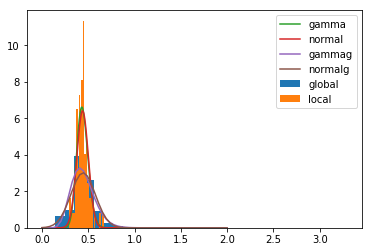

In [60]:

k_del1,theta_del1=MLE_gamma(deltA[1:100])
deltx1=np.linspace(0,1,200)
delt_gamma1=sps.gamma.pdf(x=deltx1, a=k_del1, scale=theta_del1)
delt_normal1=sps.norm.pdf(x=deltx1,loc=deltA[1:100].mean(),scale=deltA[1:100].std())
plt.hist(deltas,bins = 30,density=True, label='global')
plt.hist(deltA[1:100], bins=30,density=True, label='local' )
plt.plot(deltx1,delt_gamma1, label = 'gamma')
plt.plot(deltx1, delt_normal1, label = 'normal')
plt.plot(deltx, delt_gamma, label='gammag')
plt.plot(deltx,delt_normal, label= 'normalg')
plt.legend()

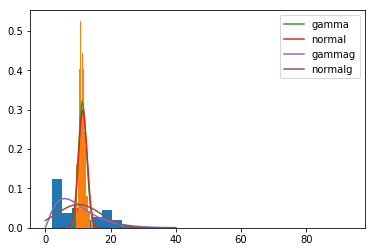

In [62]:

k_ktl1,theta_ktl1=MLE_gamma(ktlA[1:100])
ktlx1=np.linspace(5,20,200)
ktl_gamma1=sps.gamma.pdf(x=ktlx1, a=k_ktl1, scale=theta_ktl1)
ktl_normal1=sps.norm.pdf(x=ktlx1,loc=ktlA[1:100].mean(),scale=ktlA[1:100].std())
plt.hist(ktl_val, bins = 30,density=True )
plt.hist(ktlA[1:100], bins=30,density=True)
plt.plot(ktlx1,ktl_gamma1, label = 'gamma')
plt.plot(ktlx1, ktl_normal1, label = 'normal')
plt.plot(ktlx, ktl_gamma, label= 'gammag')
plt.plot(ktlx,ktl_normal, label= 'normalg')
plt.legend()

In [57]:
#Displayed graphs show that local distributions are much different than the global distributions
#Could include loop to show more than just the first data set's d & Ktl values, but would probably be ugly displayed